Source: https://github.com/juba/StableDiffusionNotebook

# Stable Diffusion custom notebook

Sources : 

- Stable Diffusion Github repo : https://github.com/CompVis/stable-diffusion
- Stable Diffusion HugginfaceHub page :https://huggingface.co/CompVis/stable-diffusion-v1-4
- Sample Hugginface diffusers notebook : https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

Ressources :

- Training set exploration : https://rom1504.github.io/clip-retrieval/

# 1. Setup

In [2]:
#@title 1.1 Check allocated GPU
!nvidia-smi

Mon Sep  5 16:01:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#@title 1.2 Install Python dependencies
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 5.2 MB/s 
     |████████████████████████████████| 120 kB 28.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.8 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 


In [4]:
#@title 1.3 Google Drive
import os
import json
from glob import glob

use_google_drive = True #@param{type: 'boolean'}

if use_google_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/AI/Stable_Diffusion'
  # Output dir
  modelPath = f'{root_path}/models'
  os.makedirs(modelPath, exist_ok=True)
  # Output dir
  outDirPath = f'{root_path}/images_out'
  os.makedirs(outDirPath, exist_ok=True)
  # Index for file names
  file_count = len(glob(outDirPath+"/*.txt")) + 1


Mounted at /content/drive


In [5]:
#@title 1.4 Downloading model
import torch
from diffusers import StableDiffusionPipeline

use_float16_precision = False#@param {type:"boolean"}
load_model_from_google_drive = True #@param{type: 'boolean'}
save_model_to_google_drive = False #@param{type: 'boolean'}
model_subdir = "float16" if use_float16_precision else "float32"

if not(load_model_from_google_drive):
  # Load model from Huggingface

  from google.colab import output
  output.enable_custom_widget_manager()

  from huggingface_hub import notebook_login
  notebook_login()

In [6]:
#@title
if not(load_model_from_google_drive):
  print(f"Loading model from Huggingface")
  if use_float16_precision:
    pipe = StableDiffusionPipeline.from_pretrained(
      "CompVis/stable-diffusion-v1-4", 
      revision="fp16", torch_dtype=torch.float16, 
      use_auth_token=True
    )
  else:
    pipe = StableDiffusionPipeline.from_pretrained(
      "CompVis/stable-diffusion-v1-4", 
      use_auth_token=True
    )
  # Optionnaly save it to Drive
  if save_model_to_google_drive:
    print(f"Saving model to {modelPath}/{model_subdir}/")
    pipe.save_pretrained(f"{modelPath}/{model_subdir}/")

else:
  print(f"Loading model from {modelPath}/{model_subdir}/")
  pipe = StableDiffusionPipeline.from_pretrained(f"{modelPath}/{model_subdir}/")

Loading model from /content/drive/MyDrive/AI/Stable_Diffusion/models/float32/


In [7]:
#@title 1.5 Utility code and functions

from PIL import Image
from torch import autocast
import random

# Move pipeline to GPU
pipe = pipe.to("cuda")

# Image grid utility
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# Do diffusion
def do_diffuse(pipe, params):
  
  num_images = params['images_rows'] * params['images_cols']
  prompt = [params['prompt']] * num_images

  seed = params['seed']
  if seed == -1:
    random.seed()
    seed = random.randint(0, 2**32)

  generator = torch.Generator("cuda").manual_seed(seed)

  with autocast("cuda"):
    out = pipe(
        prompt,
        num_inference_steps=params['num_inference_steps'],
        guidance_scale=params['guidance_scale'],
        width=params['width'],
        height=params['height'],
        generator=generator
    )["sample"]
  
  if num_images > 1:
    out = image_grid(out, rows=params['images_rows'], cols=params['images_cols'])
  else:
    out = out[0]

  return (out, seed)



# 2. Generate images


In [8]:
import datetime
import os

def run_prompt(
  prompt,
  num_inference_steps = 50,
  guidance_scale = 8,
  width = 512,
  height = 512,
  images_rows = 1,
  images_cols = 1,
  seed = -1,
):
  
  params = {
      'prompt': prompt,
      'num_inference_steps': num_inference_steps,
      'guidance_scale': guidance_scale,
      'width': width,
      'height': height,
      'images_rows': images_rows,
      'images_cols': images_cols,
      'use_float16': use_float16_precision,
      'seed': seed
  }

  image, seed = do_diffuse(pipe, params)

  if use_google_drive:
    # Save settings
    seed_orig = params['seed']
    params['seed'] = seed
    
    date = datetime.datetime.now().isoformat()
    os.makedirs(f"{outDirPath}/{date}")

    with open(f"{outDirPath}/{date}/settings.txt", "w+") as f:   #save settings
          json.dump(params, f, ensure_ascii=False, indent=4)
    # Save image
    image.save(f"{outDirPath}/{date}/img.jpg")
    params['seed'] = seed_orig

  print(f"Using seed : {seed}")
  display(image)

0it [00:00, ?it/s]

Using seed : 1227882199


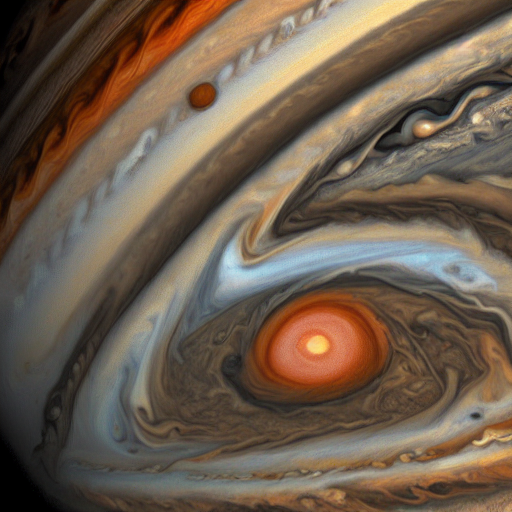

In [9]:
run_prompt("Jupiter's Great Red Spot")

0it [00:00, ?it/s]

Using seed : 2981636292


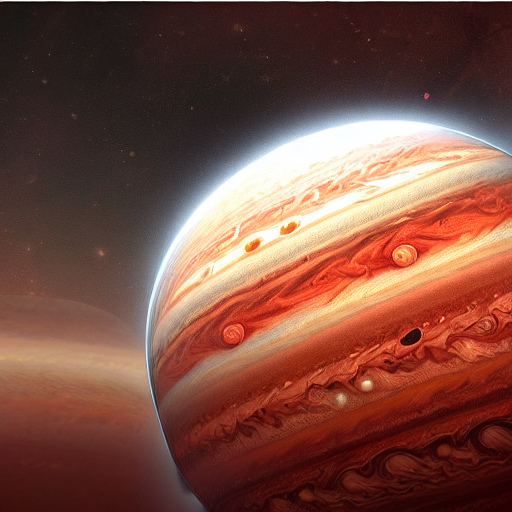

In [10]:
run_prompt("Jupiter's Great Red Spot trending on ArtStation")

0it [00:00, ?it/s]

Using seed : 361072189


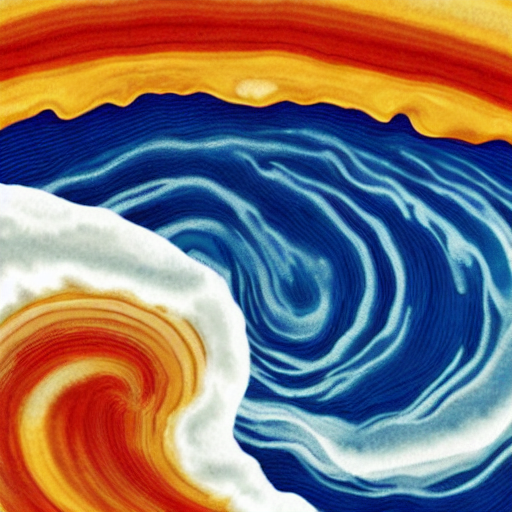

In [11]:
run_prompt("Jupiter's Great Red Spot in the style of The Great Wave")

0it [00:00, ?it/s]

Using seed : 403359354


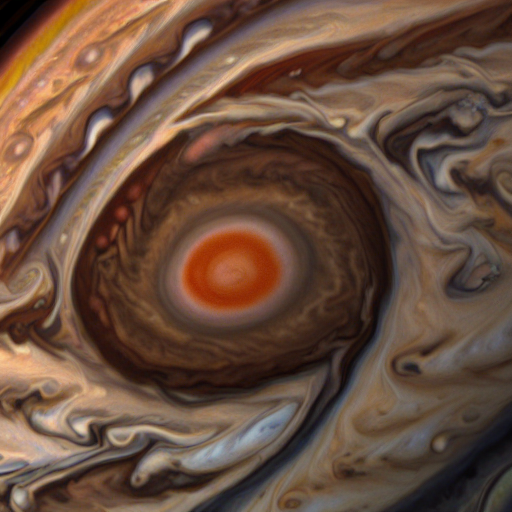

In [12]:
run_prompt("Jupiter's Great Red Spot in the style of carl sagan")

0it [00:00, ?it/s]

Using seed : 3845091128


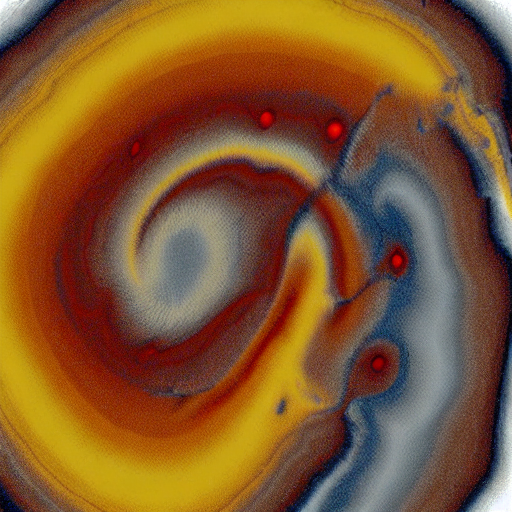

In [13]:
run_prompt("Jupyter's Great Red Spot")

0it [00:00, ?it/s]

Using seed : 2507021776


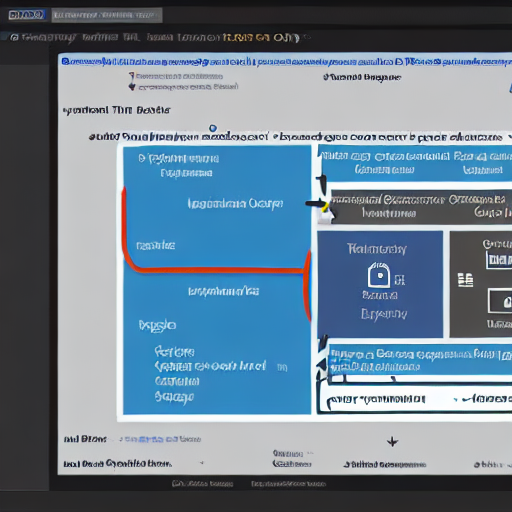

In [14]:
run_prompt("The open source Jupyter ecosystem")

0it [00:00, ?it/s]

Using seed : 3199350127


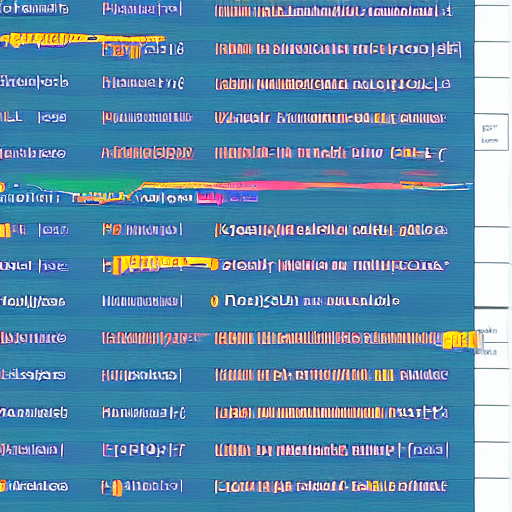

In [15]:
run_prompt("A Jupyter notebook")

0it [00:00, ?it/s]

Using seed : 1559293338


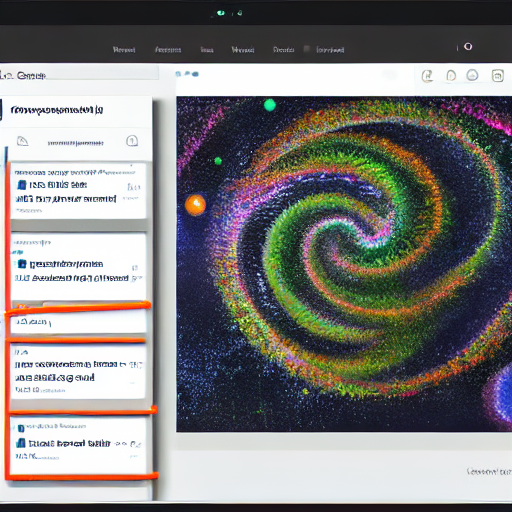

In [16]:
run_prompt("A Jupyter notebook open in the browser")

0it [00:00, ?it/s]

Using seed : 1201735032


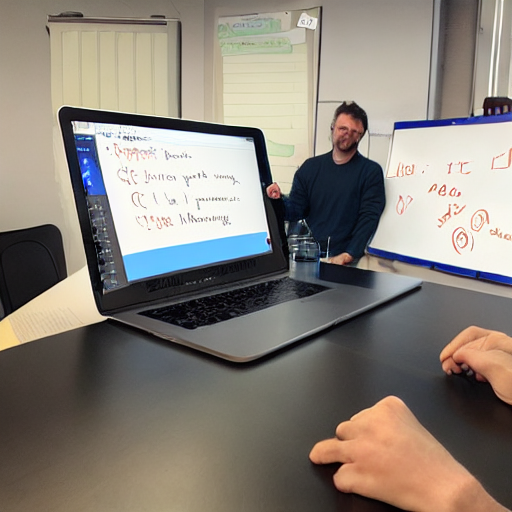

In [17]:
run_prompt("A collaborative whiteboarding app for Jupyter notebooks")